In [2]:
from IPython.display import clear_output, display

In [3]:
%pip install torch torchvision pillow spacy numpy
%pip install torchtext
%pip install pycocotools

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
import os
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CocoCaptions

from tqdm import tqdm

from PIL import Image
import spacy

In [5]:
dataset_variant = 'val2017'

## Downloading the data

In [6]:
# Define paths for dataset and annotations
data_dir = './data'
images_dir = os.path.join(data_dir, dataset_variant)
annotations_dir = os.path.join(data_dir, 'annotations')

# Create directories if they don't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
if not os.path.exists(annotations_dir):
    os.makedirs(annotations_dir)

# Download dataset
!wget http://images.cocodataset.org/zips/{dataset_variant}.zip -P {data_dir}

# Unzip dataset
!unzip {data_dir}/{dataset_variant}.zip -d {data_dir}

clear_output()


In [7]:
# Download annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {annotations_dir}

# # Unzip annotations
!unzip {annotations_dir}/annotations_trainval2017.zip -d {annotations_dir}

clear_output()

## Loading the Dataset

In [8]:
transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )

# Load MS-COCO dataset
train_dataset = CocoCaptions(root=f'./data/{dataset_variant}', annFile=f'./data/annotations/annotations/captions_{dataset_variant}.json', transform=transform)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


# 1. Tokenization and Vocab



In [9]:
import spacy

nlp = spacy.load("en_core_web_sm")

def word_tokenize(text):
    return [tok.text.lower() for tok in nlp.tokenizer(text)]

def build_vocab(dataset):
    word_freq = {}
    for _, captions in dataset:
        for caption in captions:
            tokens = word_tokenize(caption)
            for token in tokens:
                if token not in word_freq:
                    word_freq[token] = 1
                else:
                    word_freq[token] += 1

    # Add special tokens
    word_to_index = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
    for word in word_freq.keys():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

    index_to_word = {v: k for k, v in word_to_index.items()}

    return word_to_index, index_to_word, word_freq

# Build vocabulary
word_to_index, index_to_word, word_freq = build_vocab(train_dataset)

print(f"Vocabulary size: {len(word_to_index)}")

def numericalize_caption(caption):
    tokens = word_tokenize(caption)
    return [word_to_index.get(token, word_to_index['<UNK>']) for token in tokens]


Vocabulary size: 7228


In [ ]:
# # Example usage
# img, captions = train_dataset[0]
# print("Original caption:", captions[0])
# print("Tokenized and numericalized caption:", numericalize_caption(captions[0]))

# # Example of manually adding <SOS> and <EOS>
# numerized_caption = numericalize_caption(captions[0])
# full_caption = [word_to_index['<SOS>']] + numerized_caption + [word_to_index['<EOS>']]
# print("Caption with manually added <SOS> and <EOS>:", full_caption)

Original caption: A woman stands in the dining area at the table.
Tokenized and numericalized caption: [4, 5, 6, 7, 8, 9, 10, 11, 8, 12, 13]
Caption with manually added <SOS> and <EOS>: [1, 4, 5, 6, 7, 8, 9, 10, 11, 8, 12, 13, 2]


# 2. Padding and 3. Splitting



In [10]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split

torch.manual_seed(42)
random.seed(42)

class CaptionDataset(Dataset):
    def __init__(self, coco_dataset, word_to_index, transform=None):
        self.coco_dataset = coco_dataset
        self.word_to_index = word_to_index
        self.transform = transform

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, captions = self.coco_dataset[idx]


        caption = random.choice(captions)

        # Tokenize and numericalize the caption
        caption = self.numericalize_caption(caption)

        return img, caption

    def numericalize_caption(self, caption):
        tokens = word_tokenize(caption)
        return [self.word_to_index['<SOS>']] + [self.word_to_index.get(token, self.word_to_index['<UNK>']) for token in tokens] + [self.word_to_index['<EOS>']]

def collate_fn(batch):
    imgs, captions = zip(*batch)


    imgs = torch.stack(imgs)

    # Pad captions for same length
    captions = pad_sequence([torch.LongTensor(cap) for cap in captions], batch_first=True, padding_value=word_to_index['<PAD>'])

    return imgs, captions

# Create the dataset
caption_dataset = CaptionDataset(train_dataset, word_to_index)

# Split the dataset
total_size = len(caption_dataset)
print(len(caption_dataset))
train_size = int(0.9 * total_size)
test_size = total_size - train_size


generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(caption_dataset, [train_size, test_size], generator=generator)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")



5000
Train dataset size: 4500
Test dataset size: 500


# 4. Image Encoder



In [11]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        self.resnet = models.resnet50(pretrained=True).requires_grad_(False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):

        features = self.resnet(images)
        return self.dropout(self.relu(features))



# 5. LSTM Decoder



In [12]:
import torch
import torch.nn as nn

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderLSTM, self).__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
      embeddings = self.embed(captions)
      inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
      lstm_out, _ = self.lstm(inputs)
      outputs = self.linear(lstm_out)
      return outputs[:, 1:, :]




# 6. Training



In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
from tqdm import tqdm

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderLSTM(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, max_length=20):
        feature = self.encoder(image.unsqueeze(0))


        caption = []
        input_word = torch.tensor([word_to_index['<SOS>']]).unsqueeze(0).to(image.device)

        # Generate caption word by word
        for _ in range(max_length):
            output = self.decoder(feature, input_word)
            predicted = output.argmax(2)[:, -1]

            if predicted.item() == word_to_index['<EOS>']:
                break

            caption.append(predicted.item())
            input_word = predicted.unsqueeze(0)

        return [index_to_word[idx] for idx in caption]



In [14]:


# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            captions = captions.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, captions[:, :-1])


            outputs = outputs.reshape(-1, outputs.size(2))
            targets = captions[:, 1:].contiguous().view(-1)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Set up the model and training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256
hidden_size = 512
num_layers = 2


model = ImageCaptioningModel(embed_size, hidden_size, len(word_to_index), num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 70


train_model(model, train_loader, criterion, optimizer, num_epochs, device)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]
Epoch 1/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [1/70], Loss: 5.2326


Epoch 2/70: 100%|██████████| 141/141 [01:06<00:00,  2.11it/s]


Epoch [2/70], Loss: 4.3249


Epoch 3/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [3/70], Loss: 3.9848


Epoch 4/70: 100%|██████████| 141/141 [01:07<00:00,  2.09it/s]


Epoch [4/70], Loss: 3.8544


Epoch 5/70: 100%|██████████| 141/141 [01:07<00:00,  2.09it/s]


Epoch [5/70], Loss: 3.7378


Epoch 6/70: 100%|██████████| 141/141 [01:07<00:00,  2.09it/s]


Epoch [6/70], Loss: 3.6093


Epoch 7/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [7/70], Loss: 3.5239


Epoch 8/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [8/70], Loss: 3.4446


Epoch 9/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [9/70], Loss: 3.3483


Epoch 10/70: 100%|██████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch [10/70], Loss: 3.2716


Epoch 11/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [11/70], Loss: 3.1916


Epoch 12/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [12/70], Loss: 3.1310


Epoch 13/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [13/70], Loss: 3.0548


Epoch 14/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [14/70], Loss: 2.9892


Epoch 15/70: 100%|██████████| 141/141 [01:07<00:00,  2.09it/s]


Epoch [15/70], Loss: 2.9060


Epoch 16/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [16/70], Loss: 2.8548


Epoch 17/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [17/70], Loss: 2.8060


Epoch 18/70: 100%|██████████| 141/141 [01:07<00:00,  2.09it/s]


Epoch [18/70], Loss: 2.7294


Epoch 19/70: 100%|██████████| 141/141 [01:07<00:00,  2.10it/s]


Epoch [19/70], Loss: 2.7012


Epoch 20/70: 100%|██████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch [20/70], Loss: 2.6394


Epoch 21/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [21/70], Loss: 2.6050


Epoch 22/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [22/70], Loss: 2.5592


Epoch 23/70: 100%|██████████| 141/141 [01:07<00:00,  2.07it/s]


Epoch [23/70], Loss: 2.5024


Epoch 24/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [24/70], Loss: 2.4764


Epoch 25/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [25/70], Loss: 2.4276


Epoch 26/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [26/70], Loss: 2.3845


Epoch 27/70: 100%|██████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch [27/70], Loss: 2.3648


Epoch 28/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [28/70], Loss: 2.3172


Epoch 29/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [29/70], Loss: 2.2745


Epoch 30/70: 100%|██████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch [30/70], Loss: 2.2369


Epoch 31/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [31/70], Loss: 2.1965


Epoch 32/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [32/70], Loss: 2.1502


Epoch 33/70: 100%|██████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch [33/70], Loss: 2.1229


Epoch 34/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [34/70], Loss: 2.0796


Epoch 35/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [35/70], Loss: 2.0535


Epoch 36/70: 100%|██████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch [36/70], Loss: 2.0244


Epoch 37/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [37/70], Loss: 1.9846


Epoch 38/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [38/70], Loss: 1.9629


Epoch 39/70: 100%|██████████| 141/141 [01:09<00:00,  2.04it/s]


Epoch [39/70], Loss: 1.9184


Epoch 40/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [40/70], Loss: 1.8885


Epoch 41/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [41/70], Loss: 1.8715


Epoch 42/70: 100%|██████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch [42/70], Loss: 1.8207


Epoch 43/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [43/70], Loss: 1.8025


Epoch 44/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [44/70], Loss: 1.7768


Epoch 45/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [45/70], Loss: 1.7381


Epoch 46/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [46/70], Loss: 1.7016


Epoch 47/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [47/70], Loss: 1.6861


Epoch 48/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [48/70], Loss: 1.6645


Epoch 49/70: 100%|██████████| 141/141 [01:07<00:00,  2.07it/s]


Epoch [49/70], Loss: 1.6380


Epoch 50/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [50/70], Loss: 1.6030


Epoch 51/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [51/70], Loss: 1.5596


Epoch 52/70: 100%|██████████| 141/141 [01:07<00:00,  2.07it/s]


Epoch [52/70], Loss: 1.5473


Epoch 53/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [53/70], Loss: 1.5429


Epoch 54/70: 100%|██████████| 141/141 [01:07<00:00,  2.09it/s]


Epoch [54/70], Loss: 1.4920


Epoch 55/70: 100%|██████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch [55/70], Loss: 1.4864


Epoch 56/70: 100%|██████████| 141/141 [01:07<00:00,  2.07it/s]


Epoch [56/70], Loss: 1.4605


Epoch 57/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [57/70], Loss: 1.4208


Epoch 58/70: 100%|██████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch [58/70], Loss: 1.3984


Epoch 59/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [59/70], Loss: 1.3975


Epoch 60/70: 100%|██████████| 141/141 [01:07<00:00,  2.09it/s]


Epoch [60/70], Loss: 1.3601


Epoch 61/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [61/70], Loss: 1.3404


Epoch 62/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [62/70], Loss: 1.3238


Epoch 63/70: 100%|██████████| 141/141 [01:07<00:00,  2.09it/s]


Epoch [63/70], Loss: 1.3152


Epoch 64/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [64/70], Loss: 1.2854


Epoch 65/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [65/70], Loss: 1.2740


Epoch 66/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]


Epoch [66/70], Loss: 1.2700


Epoch 67/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [67/70], Loss: 1.2423


Epoch 68/70: 100%|██████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch [68/70], Loss: 1.2141


Epoch 69/70: 100%|██████████| 141/141 [01:08<00:00,  2.07it/s]


Epoch [69/70], Loss: 1.2099


Epoch 70/70: 100%|██████████| 141/141 [01:07<00:00,  2.08it/s]

Epoch [70/70], Loss: 1.1884


In [15]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')

def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_references = []

    sos_token = '<SOS>'
    eos_token = '<EOS>'
    pad_token = '<PAD>'

    with torch.no_grad():
        for images, captions in tqdm(data_loader, desc="Evaluating"):
            images = images.to(device)

            # Generate captions
            for i in range(images.size(0)):
                try:
                    predicted_caption = model.generate_caption(images[i])
                    all_predictions.append(predicted_caption)


                    reference_caption = [index_to_word[idx.item()] for idx in captions[i] if idx.item() not in [word_to_index[sos_token], word_to_index[eos_token], word_to_index[pad_token]]]
                    all_references.append([reference_caption])
                except Exception as e:
                    print(f"Error generating caption for image {i}: {str(e)}")
                    continue

    if not all_predictions:
        print("No captions were successfully generated. Unable to calculate BLEU score.")
        return 0


    bleu_score = corpus_bleu(all_references, all_predictions, weights=(0.25, 0.25, 0.25, 0.25))

    print(f"BLEU Score: {bleu_score:.4f}")

    return bleu_score

# After training, evaluate the model
print("Evaluating the model...")
bleu_score = evaluate_model(model, test_loader, device)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Evaluating the model...


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

BLEU Score: 0.0096


Generating captions for random images...


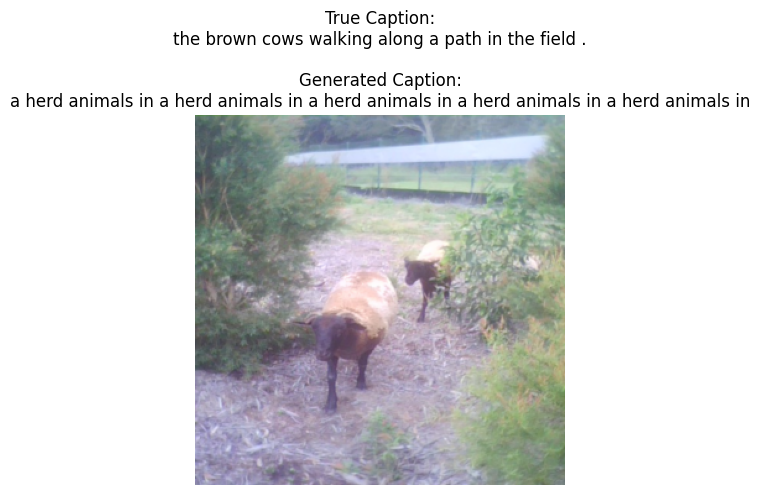

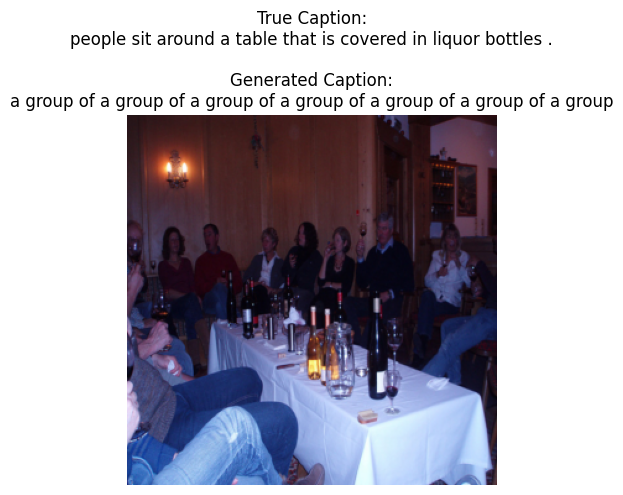

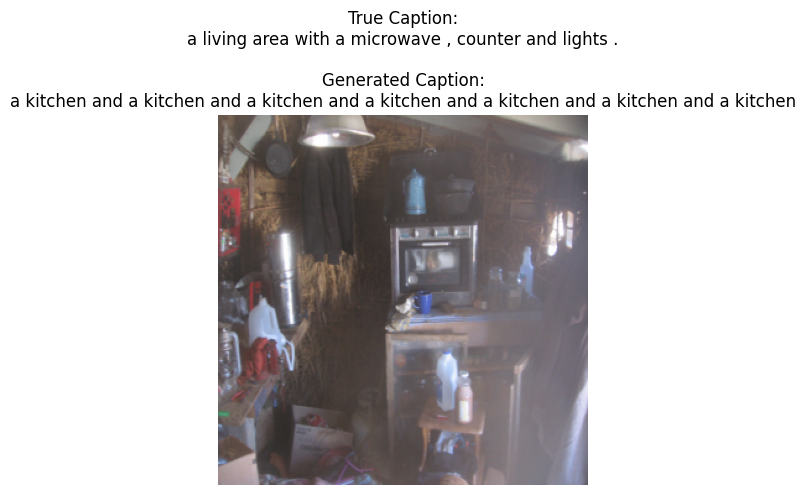

In [38]:
def show_random_images_with_captions(model, test_dataset, device, num_images=3):
    model.eval()

    if isinstance(test_dataset, torch.utils.data.Subset):
        original_dataset = test_dataset.dataset
    else:
        original_dataset = test_dataset

    # Select random indices
    random_indices = random.sample(range(len(test_dataset)), num_images)

    with torch.no_grad():
        for idx in random_indices:
            # Get the image and caption
            image, true_caption_indices = test_dataset[idx]

            # Move image to device and add batch dimension
            image = image.unsqueeze(0).to(device)

            # Generate caption
            generated_caption = model.generate_caption(image.squeeze(0))
            generated_caption_text = ' '.join(generated_caption)

            # Convert true caption indices to text
            true_caption_text = ' '.join([index_to_word[idx] for idx in true_caption_indices if idx not in [word_to_index['<SOS>'], word_to_index['<EOS>'], word_to_index['<PAD>']]])

            # Display the image
            show_image(image.squeeze(0).cpu(), title=f"True Caption:\n{true_caption_text}\n\nGenerated Caption:\n{generated_caption_text}")

# After training the model
print("Generating captions for random images...")
show_random_images_with_captions(model, test_dataset, device)